# Camera mapping

To use the RGB images as labels for the IRCCAM data, we need a way to map the RGB view to the IRCCAM view. This notebook explores a few approaches to aligning the two views.

The first approach is to detect SIFT features (see here https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect6.pdf) in the two images, match corresponding features and align using the matches.

## IRCCAM data

In [2]:
import mat73 # scipy wouldn't load matlab 7.3 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib.pyplot import figure

In [4]:
idata = mat73.loadmat('../data/davos/irrcam/irccam_20190816_rad.mat')

In [5]:
idata.keys()

dict_keys(['AZ', 'BT', 'CF', 'CLOUDS', 'CSFIT', 'CameraToffset', 'IRR', 'TM', 'ZA', 'alphadata', 'cloudheight', 'img', 'meteo', 'temp', 'temps', 'tempsstr', 'thor'])

In [6]:
imgnum = 600

In [7]:
idata['img'][:,:,imgnum]

array([[240.59251, 244.1211 , 247.93852, ..., 268.0701 , 269.1212 ,
        270.00278],
       [237.16144, 239.24812, 242.33423, ..., 269.27264, 270.05286,
        271.0733 ],
       [235.32957, 236.38731, 238.02786, ..., 270.3011 , 271.41345,
        272.78214],
       ...,
       [262.15884, 262.04288, 261.97452, ..., 223.55362, 223.64934,
        223.78435],
       [262.0303 , 261.9505 , 262.04398, ..., 223.53189, 223.56403,
        223.65323],
       [261.97092, 262.01633, 262.10037, ..., 223.52045, 223.58525,
        223.55249]], dtype=float32)

In [8]:
def plotfig(img):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    implot = plt.imshow(img, cmap='gray')

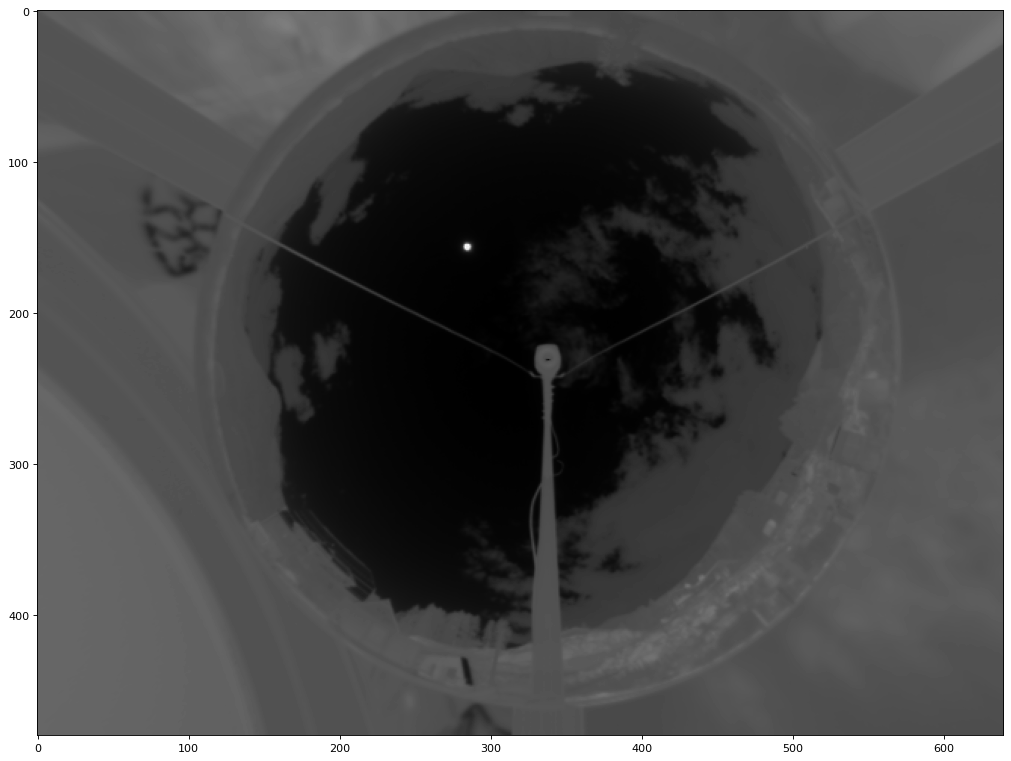

In [9]:
plotfig(idata['img'][:,:,600])

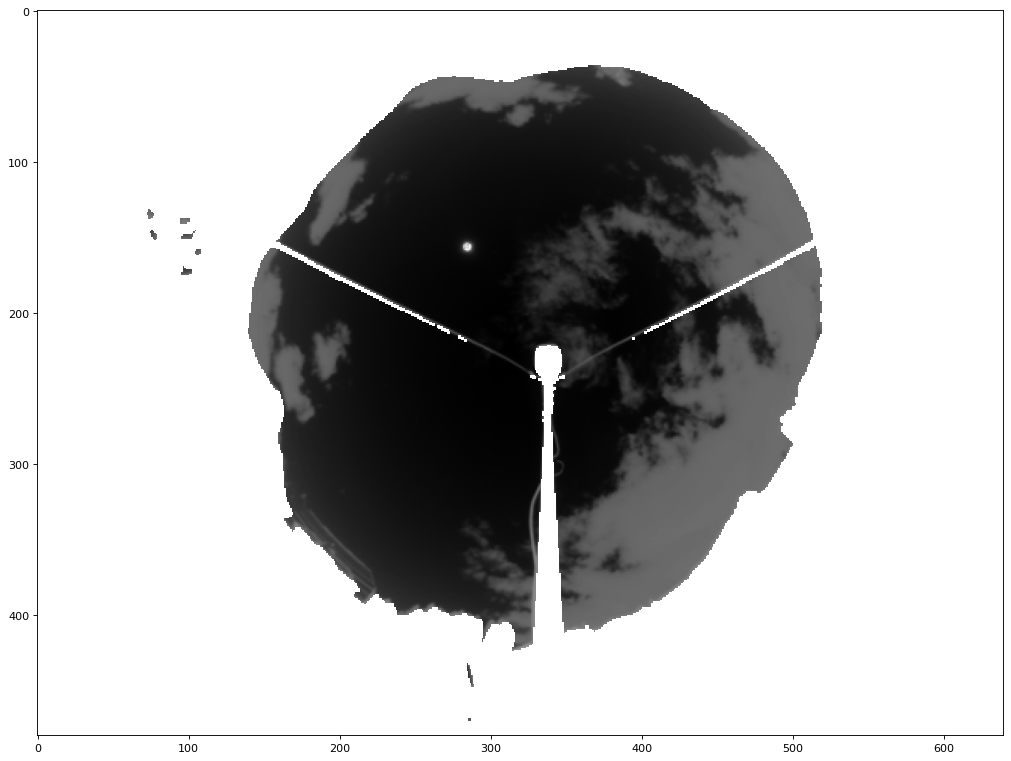

In [10]:
plotfig(idata['BT'][:,:,imgnum])

## RGB data

In [11]:
img = plt.imread('../data/davos/rgb/20190816/20190816100000_0.jpg')

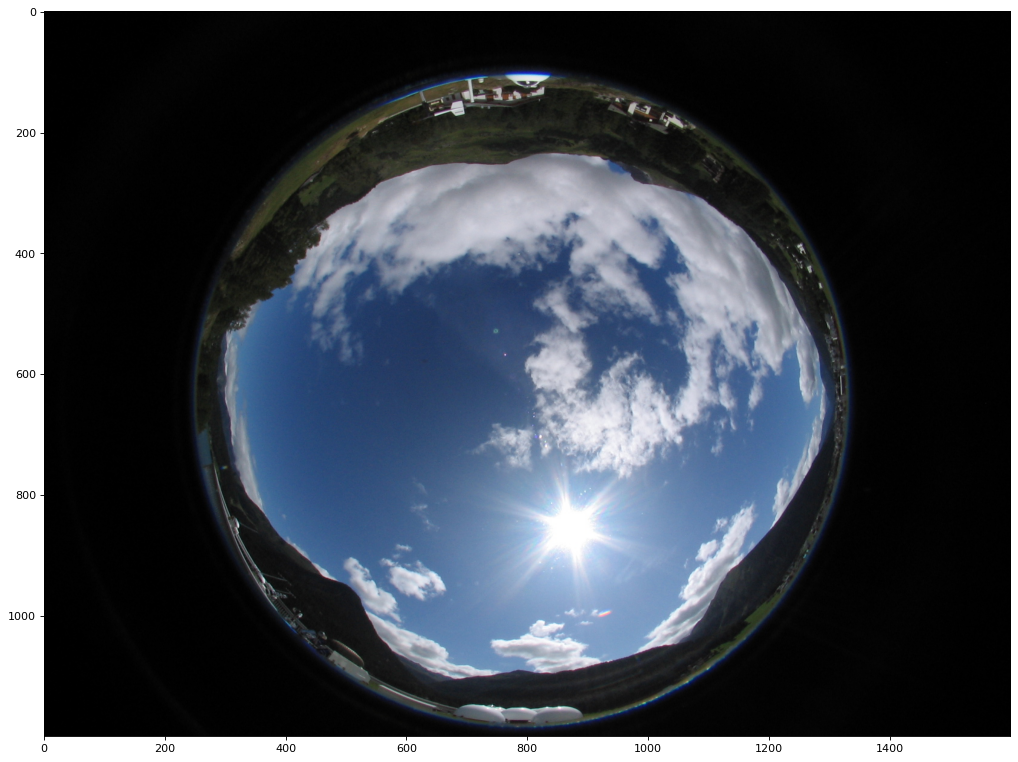

In [12]:
plotfig(img)

## SIFT feature mapping

In [14]:
import cv2

In [15]:
sift = cv2.SIFT_create()

In [59]:
img = cv2.imread('../data/davos/rgb/20190816/20190816100000_0.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
imgkp = cv2.drawKeypoints(gray,kp,img)

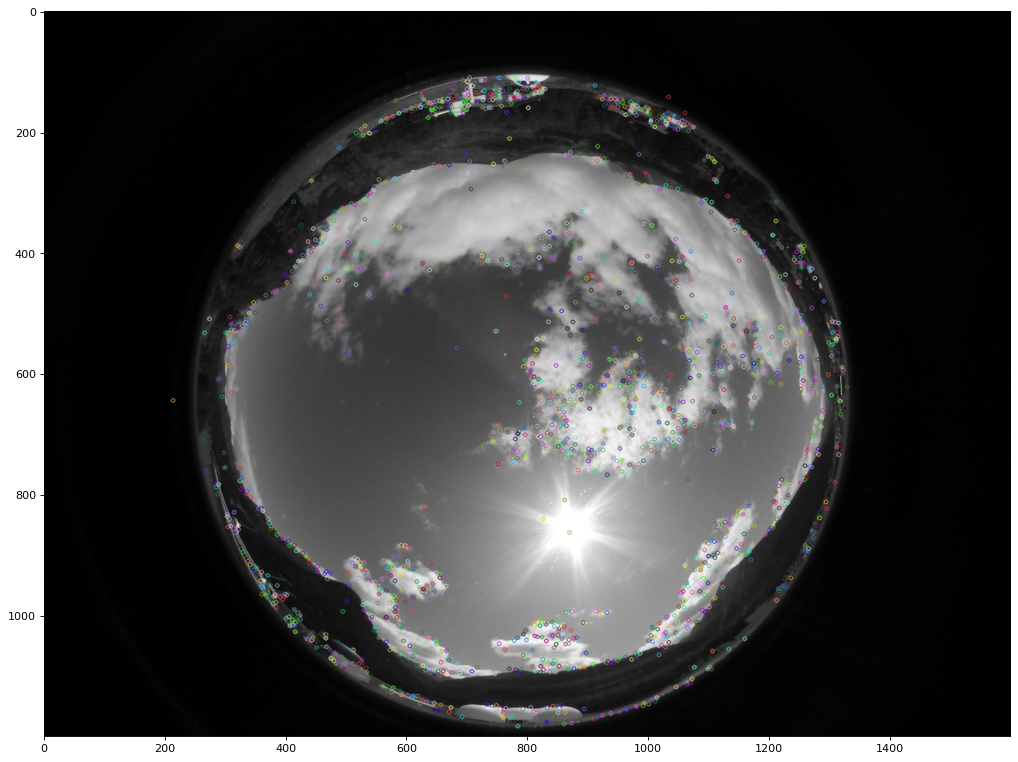

In [60]:
plotfig(imgkp)

In [49]:
ir_600 = idata['img'][:,:,600]
gray_ir = ir_600 - ir_600.min()
gray_ir *= (255.0/gray_ir.max())
gray_ir = np.array(gray_ir.round(), dtype = np.uint8)

sift = cv2.SIFT_create()
kp_ir = sift.detect(gray_ir,None)
imgkp_ir = cv2.drawKeypoints(gray_ir,kp_ir,None)

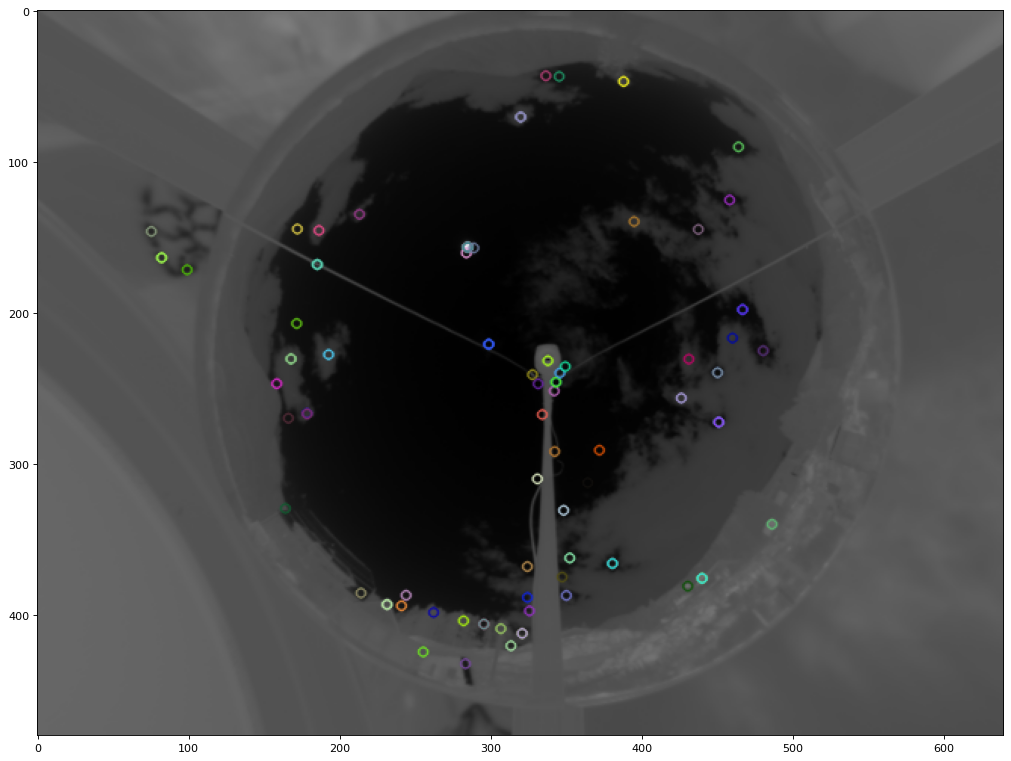

In [50]:
plotfig(imgkp_ir)

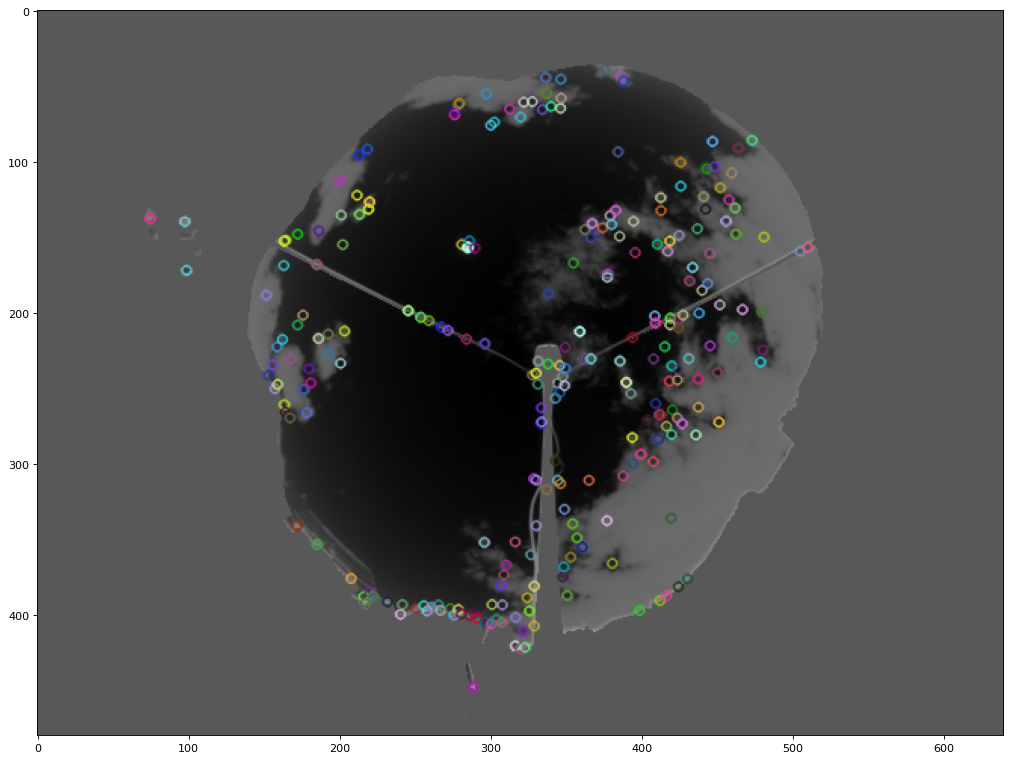

In [61]:
ir_600 = np.nan_to_num(idata['BT'][:,:,600])
gray_ir = ir_600 - ir_600.min()
gray_ir *= (255.0/gray_ir.max())
gray_ir = np.array(gray_ir.round(), dtype = np.uint8)

sift = cv2.SIFT_create()
kp_ir, des_ir = sift.detectAndCompute(gray_ir,None)
imgkp_ir = cv2.drawKeypoints(gray_ir,kp_ir,None)
plotfig(imgkp_ir)

## Crop to square 

In [140]:
def crop_irrcam_img(img):
    crop_img = img[20:440, 120:540]
    return crop_img

def crop_vis_img(img):
    crop_img = img[40:480, 95:535]
    return crop_img

def scale_vis_img(img):
    scale_img = cv2.resize(img, (640, 480))
    return scale_img

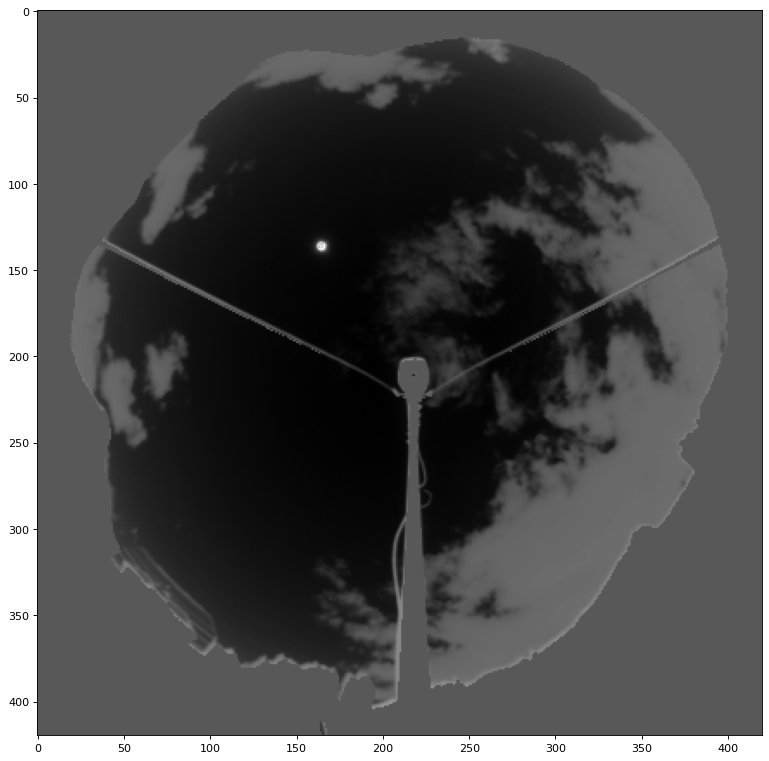

In [141]:
cropped_ir = crop_irrcam_img(gray_ir)
plotfig(cropped_ir)

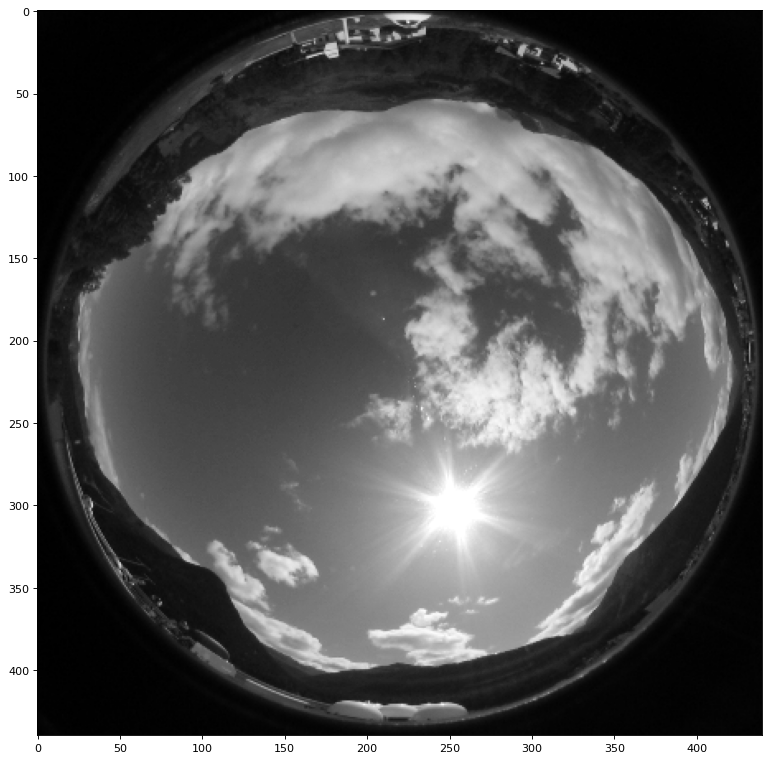

In [142]:
scaled_rgb = scale_vis_img(gray)
cropped_rgb = crop_vis_img(scaled_rgb)
plotfig(cropped_rgb)

## Rotate and flip rgb images

In [143]:
# from https://stackoverflow.com/a/23316542
def rotate_image(image, angle):
    row,col = image.shape
    center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image

def flip_and_rotate_vis_img(img):
    flip_img = cv2.flip(img, 1)
    rotate_img = rotate_image(flip_img, -130)
    return rotate_img

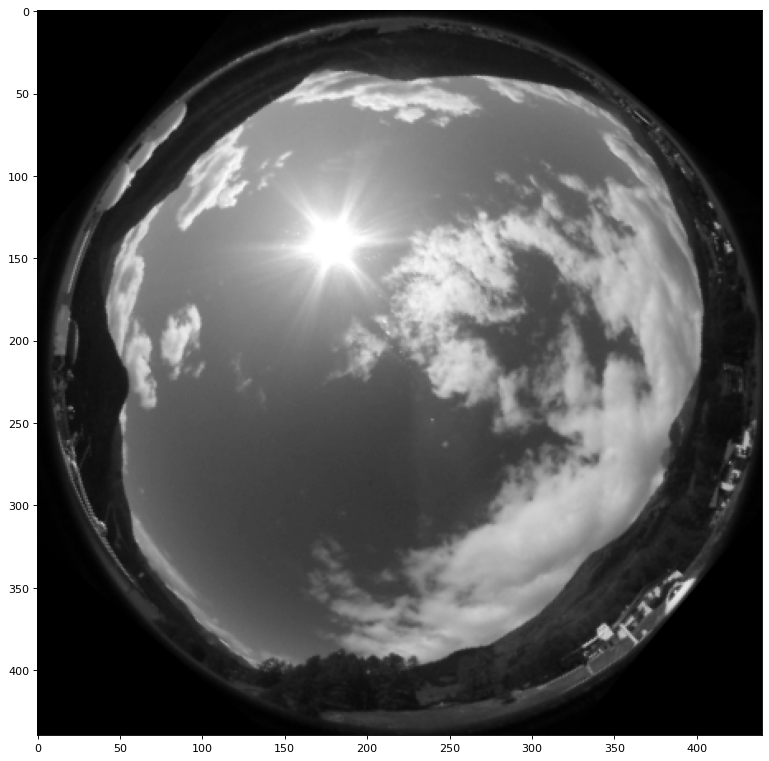

In [144]:
flipped_rgb = flip_and_rotate_vis_img(cropped_rgb)
plotfig(flipped_rgb)

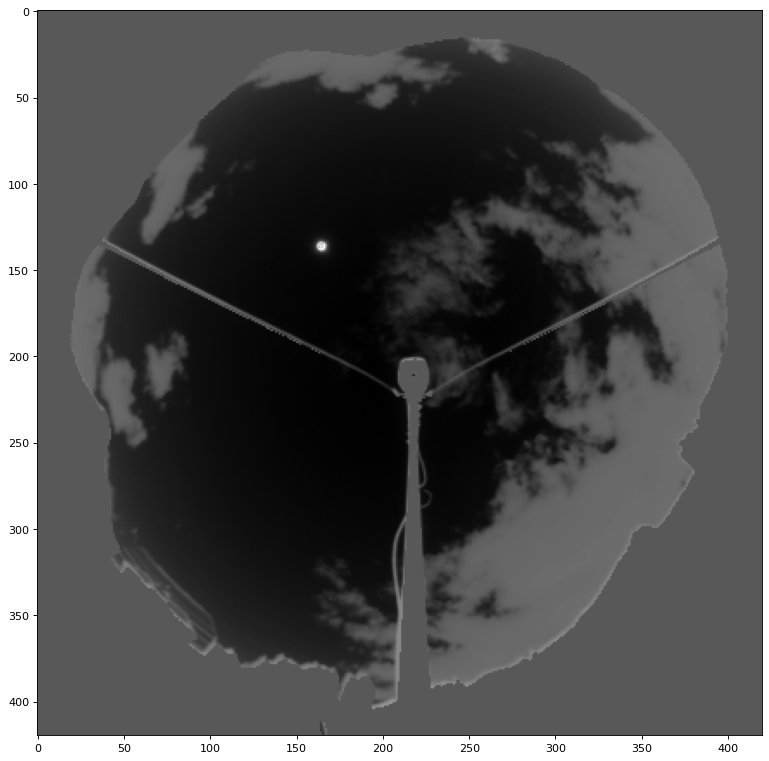

In [145]:
plotfig(cropped_ir)

## Full pre-processing

In [149]:
import datetime

def get_irccam_img(img_num):
    img_ir = idata['img'][:,:,img_num]
    gray_ir = img_ir - img_ir.min()
    gray_ir *= (255.0/gray_ir.max())
    gray_ir = np.array(gray_ir.round(), dtype = np.uint8)
    return gray_ir

def process_irccam_img(img):
    cropped_ir = crop_irrcam_img(gray_ir)
    return cropped_ir

def get_vis_img(img_num):
    time_str = (datetime.datetime(2019,8,16,0,0,0) + datetime.timedelta(minutes=img_num)).strftime('%Y%m%d%H%M')
    img_vis = cv2.imread('../data/davos/rgb/20190816/{}00_0.jpg'.format(time_str))
    gray_vis = cv2.cvtColor(img_vis,cv2.COLOR_BGR2GRAY)
    return gray_vis

def process_vis_img(img):
    processed_vis = scale_vis_img(img)
    processed_vis = crop_vis_img(processed_vis)
    processed_vis = flip_and_rotate_vis_img(processed_vis)
    return processed_vis

def get_processed_ir_img(img_num):
    img_ir = get_irccam_img(img_num)
    img_ir = process_irccam_img(img_ir)
    return img_ir

def get_processed_vis_img(img_num):
    img_vis = get_vis_img(img_num)
    img_vis = process_vis_img(img_vis)
    return img_vis

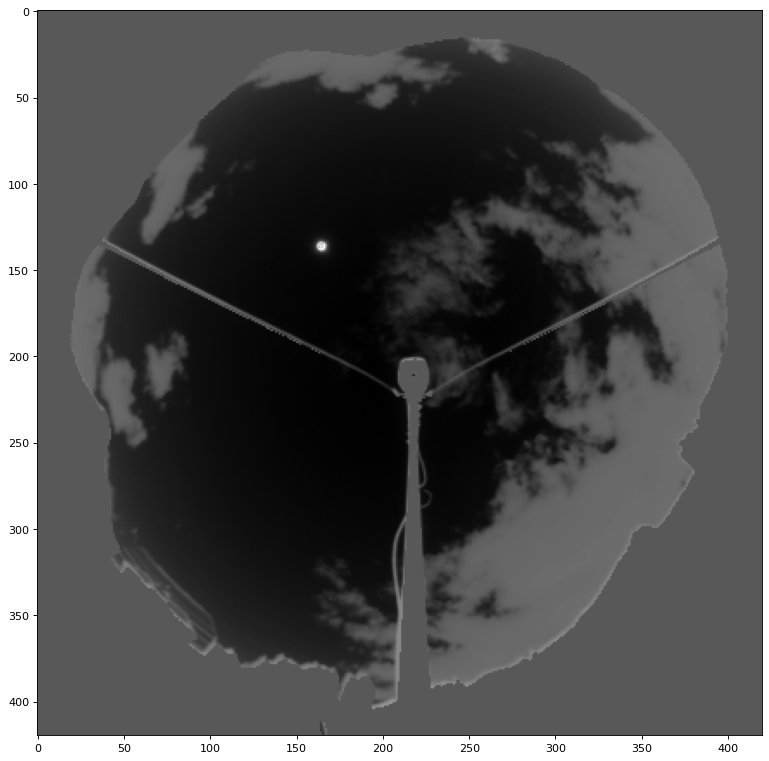

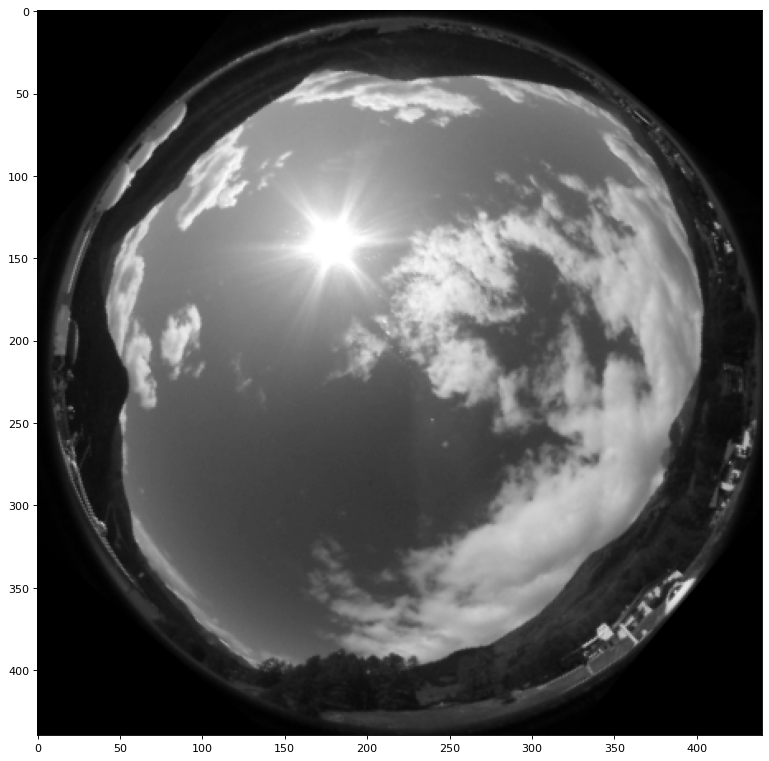

In [151]:
img_ir = get_processed_ir_img(600)
img_vis = get_processed_vis_img(600)
plotfig(img_ir)
plotfig(img_vis)

## SIFT matches

In [152]:
img_ir = get_processed_ir_img(600)
img_vis = get_processed_vis_img(600)

sift = cv2.SIFT_create()
kp_vis, des_vis = sift.detectAndCompute(img_vis, None)
kp_ir, des_ir = sift.detectAndCompute(img_ir, None)

matcher = cv2.BFMatcher()
kp_matches = matcher.match(des_vis, des_ir)

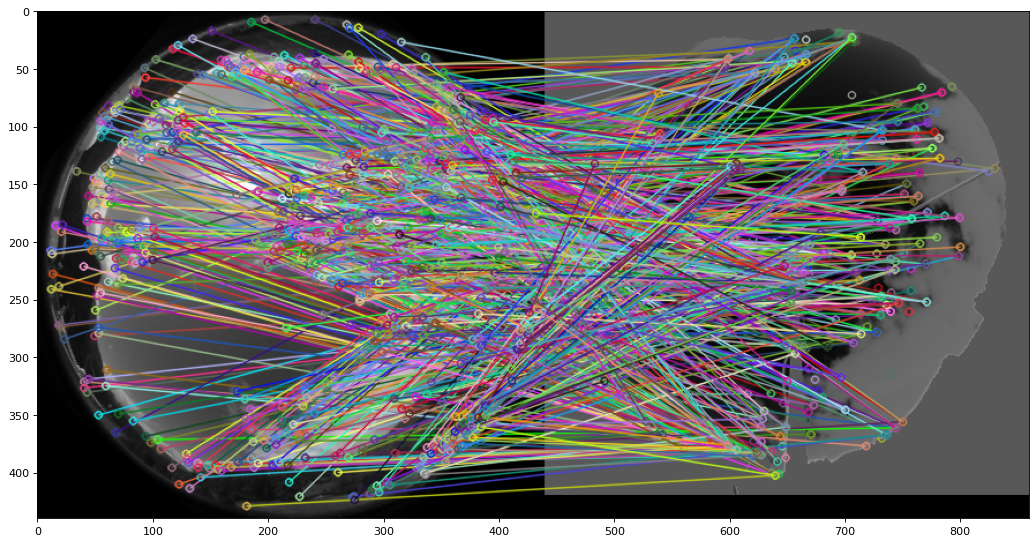

In [162]:
# Plot all matches

match_img = np.zeros((img_vis.shape[0],img_vis.shape[1],3))
match_img = cv2.drawMatches(img_vis,kp_vis,img_ir,kp_ir,kp_matches,match_img)
plotfig(match_img)

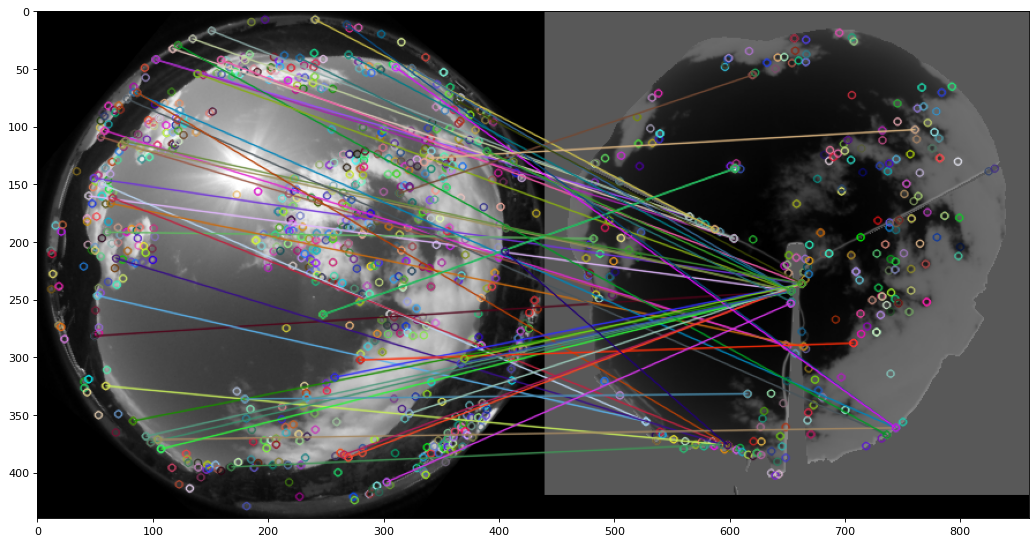

In [169]:
# Plot close matches

match_dist = np.array([a.distance for a in kp_matches])
close_matches = np.delete(kp_matches,np.where(match_dist>200))

close_match_img = np.zeros((img_vis.shape[0],img_vis.shape[1],3))
close_match_img = cv2.drawMatches(img_vis,kp_vis,img_ir,kp_ir,close_matches,close_match_img)
plotfig(close_match_img)

## Comment

This approach does not seem very successful.